<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/ARIMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [4]:
NIFTY = pd.read_csv("Database/Pre_Processed_NIFTY50.csv")

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series and help us understand if the series is stationary.

**Null Hypothesis**: The series has a unit root

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the Null Hypothesis, then the series is non-stationary.

In [5]:
def Test_Stationarity(timeseries):
  result = adfuller(timeseries['Close'], autolag = 'AIC')
  print("Results of Dickey Fuller Test")
  print(f'Test Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Number of lags used: {result[2]}')
  print(f'Number of observations used: {result[3]}')
  for key, value in result[4].items():
    print(f'critical value ({key}): {value}')

#Apple

In [6]:
NIFTY.head()

,Unnamed: 0,Date,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr),Volume
0,0,2015-01-01,8272.80,8294.70,8248.75,8284.00,56560411,2321.88,56560411.0
1,1,2015-01-02,8288.70,8410.60,8288.70,8395.45,101887024,4715.72,101887024.0
2,2,2015-01-05,8407.95,8445.60,8363.90,8378.40,118160545,5525.52,118160545.0
3,3,2015-01-06,8325.30,8327.85,8111.35,8127.35,172799618,8089.19,172799618.0
4,4,2015-01-07,8118.65,8151.20,8065.45,8102.10,164075424,7464.33,164075424.0


In [7]:
NIFTY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1380 non-null   int64  
 1   Date               1380 non-null   object 
 2   Open               1380 non-null   float64
 3   High               1380 non-null   float64
 4   Low                1380 non-null   float64
 5   Close              1380 non-null   float64
 6   Shares Traded      1380 non-null   int64  
 7   Turnover (Rs. Cr)  1380 non-null   float64
 8   Volume             1380 non-null   float64
dtypes: float64(6), int64(2), object(1)
memory usage: 97.2+ KB


In [8]:
# Change Dtype of Date column
NIFTY["Date"] = pd.to_datetime(NIFTY["Date"])

In [9]:
Test_Stationarity(NIFTY)

Results of Dickey Fuller Test
Test Statistics: -1.6546021144943188
p-value: 0.45464140442543755
Number of lags used: 11
Number of observations used: 1368
critical value (1%): -3.435139190725917
critical value (5%): -2.8636550704859007
critical value (10%): -2.5678960623995417


The p-value > 0.05, so we cannot reject the Null hypothesis. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series, to make the data stationary while building the Auto ARIMA model.

Now let's take log of the 'Adj. Close' column to reduce the magnitude of the values and reduce the series rising trend.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

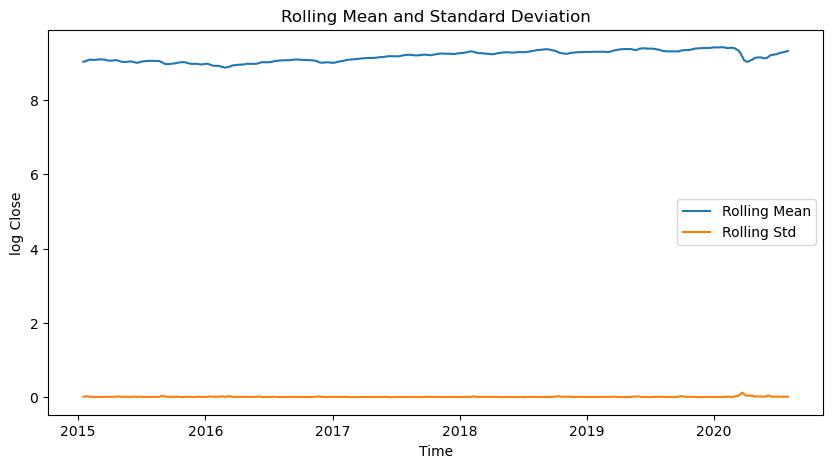

In [10]:
NIFTY['log Close'] = np.log(NIFTY['Close'])
NIFTY_log_moving_avg = NIFTY['log Close'].rolling(12).mean()
NIFTY_log_std = NIFTY['log Close'].rolling(12).std()

plt.figure(figsize = (10, 5))
plt.plot(NIFTY['Date'], NIFTY_log_moving_avg, label = "Rolling Mean")
plt.plot(NIFTY['Date'], NIFTY_log_std, label = "Rolling Std")
plt.xlabel('Time')
plt.ylabel('log Close')
plt.legend(loc = 'best')
plt.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set

    Training Period: < '2018-12-28'

    Testing Period:  >= '2018-12-28'







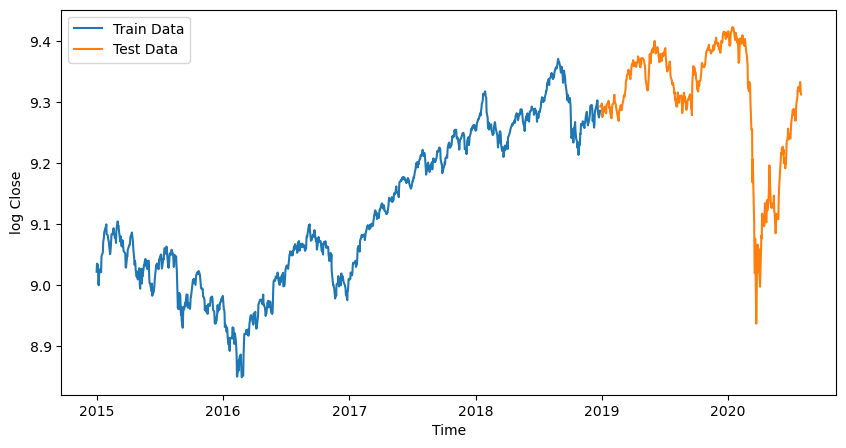

In [11]:
NIFTY_Train_Data = NIFTY[NIFTY['Date'] < '2018-12-28']
NIFTY_Test_Data = NIFTY[NIFTY['Date'] >= '2018-12-28'].reset_index(drop = True)

plt.figure(figsize = (10, 5))
plt.plot(NIFTY_Train_Data['Date'], NIFTY_Train_Data['log Close'], label = 'Train Data')
plt.plot(NIFTY_Test_Data['Date'], NIFTY_Test_Data['log Close'], label = 'Test Data')
plt.xlabel('Time')
plt.ylabel('log Close')
plt.legend(loc = 'best')

###Modeling

In [12]:
NIFTY_Auto_ARIMA_Model = auto_arima(NIFTY_Train_Data['log Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(NIFTY_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  987
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3291.814
Date:                Wed, 26 Oct 2022   AIC                          -6581.628
Time:                        16:16:07   BIC                          -6576.734
Sample:                             0   HQIC                         -6579.767
                                - 987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.366e-05   2.05e-06     35.957      0.000    6.96e-05    7.77e-05
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):               510.00
Prob(Q):                              0.09   Pr

In [13]:
NIFTY_ARIMA_Model = ARIMA(NIFTY_Train_Data['log Close'], order = (1, 1, 0))
NIFTY_ARIMA_Model_Fit = NIFTY_ARIMA_Model.fit()
print(NIFTY_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:              log Close   No. Observations:                  987
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3293.330
Date:                Wed, 26 Oct 2022   AIC                          -6582.660
Time:                        16:16:07   BIC                          -6572.872
Sample:                             0   HQIC                         -6578.937
                                - 987                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0554      0.029      1.932      0.053      -0.001       0.112
sigma2      7.343e-05   2.06e-06     35.664      0.000    6.94e-05    7.75e-05
Ljung-Box (L1) (Q):                   0.00   Jarque-

###Predicting the closing stock price of Apple

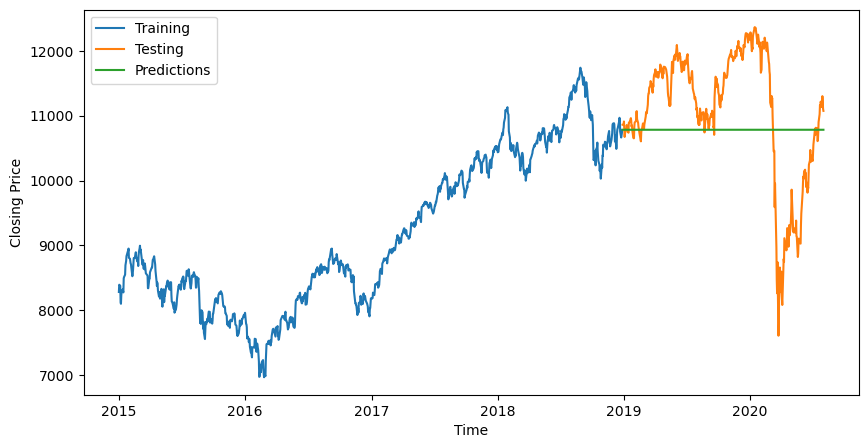

In [14]:
NIFTY_output = NIFTY_ARIMA_Model_Fit.forecast(393, alpha=0.05)
NIFTY_predictions = np.exp(NIFTY_output)
plt.figure(figsize=(10, 5))
plt.plot(NIFTY_Train_Data['Date'], NIFTY_Train_Data['Close'], label = 'Training')
plt.plot(NIFTY_Test_Data['Date'], NIFTY_Test_Data['Close'], label = 'Testing')
plt.plot(NIFTY_Test_Data['Date'], NIFTY_predictions, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()

In [15]:
rmse = math.sqrt(mean_squared_error(NIFTY_Test_Data['Close'], NIFTY_predictions))
mape = np.mean(np.abs(NIFTY_predictions.values - NIFTY_Test_Data['Close'].values)/np.abs(NIFTY_Test_Data['Close'].values))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 1026.6466046111937
MAPE: 0.07843661415275392
